# Training all Characters resnet34 32 pixels

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Looking at the data

In [3]:
#path = Path(Config.get_key('data_path')).expanduser()/'handwritten'
# /mnt/handwritten is a path specific to azure datascience machine. If it does not work, uncomment the line above
# and comment line below
path = Path('/mnt/ramdisk/handwritten')
permanent_path = Path(Config.get_key('data_path')).expanduser()/'handwritten'

In [4]:
# If this line below does not work copy and paste it in a bash shell
#! kaggle datasets download -d vaibhao/handwritten-characters
#! unzip ~/handwritten-characters.zip -d /home/bernadjm/.fastai/data/handwritten
# /mnt/handwritten is a path specific to azure datascience machine. If it does not work, uncomment the line above
# and comment line below
#! sudo chmod 777 /mnt
#! unzip ~/handwritten-characters.zip -d /mnt/handwritten

In [5]:
path.ls()

[PosixPath('/mnt/ramdisk/handwritten/Train'),
 PosixPath('/mnt/ramdisk/handwritten/Validation')]

In [6]:
path_train = path/'Train'
path_train.ls()

[PosixPath('/mnt/ramdisk/handwritten/Train/NOTHING'),
 PosixPath('/mnt/ramdisk/handwritten/Train/M'),
 PosixPath('/mnt/ramdisk/handwritten/Train/W'),
 PosixPath('/mnt/ramdisk/handwritten/Train/P'),
 PosixPath('/mnt/ramdisk/handwritten/Train/5'),
 PosixPath('/mnt/ramdisk/handwritten/Train/Y'),
 PosixPath('/mnt/ramdisk/handwritten/Train/2'),
 PosixPath('/mnt/ramdisk/handwritten/Train/L'),
 PosixPath('/mnt/ramdisk/handwritten/Train/K'),
 PosixPath('/mnt/ramdisk/handwritten/Train/B'),
 PosixPath('/mnt/ramdisk/handwritten/Train/E'),
 PosixPath('/mnt/ramdisk/handwritten/Train/3'),
 PosixPath('/mnt/ramdisk/handwritten/Train/X'),
 PosixPath('/mnt/ramdisk/handwritten/Train/4'),
 PosixPath('/mnt/ramdisk/handwritten/Train/Q'),
 PosixPath('/mnt/ramdisk/handwritten/Train/V'),
 PosixPath('/mnt/ramdisk/handwritten/Train/D'),
 PosixPath('/mnt/ramdisk/handwritten/Train/C'),
 PosixPath('/mnt/ramdisk/handwritten/Train/J'),
 PosixPath('/mnt/ramdisk/handwritten/Train/H'),
 PosixPath('/mnt/ramdisk/handwritt

In [7]:
bs = 4096 #batch size
bs = bs * torch.cuda.device_count()
size = 32
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, train='Train', valid='Validation', ds_tfms=tfms, size=size, bs=bs)
torch.cuda.device_count()

1

In [8]:
bs

4096

In [9]:
data.train_ds[0]


(Image (3, 32, 32), 0)

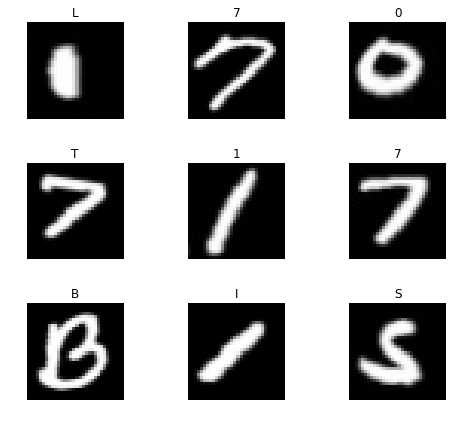

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
print(data.classes)
len(data.classes),data.c

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'NOTHING', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


(36, 36)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [12]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)
initial_model = learn.model

In [13]:
# if using single GPU DataParallel works but produces a little overhead
if torch.cuda.device_count() > 1:
    learn.model = torch.nn.DataParallel(initial_model)

In [14]:
learn.fit_one_cycle(4)

Total time: 21:27
epoch  train_loss  valid_loss  error_rate
1      0.794674    0.581663    0.165024    (05:45)
2      0.347445    0.417483    0.116942    (05:14)
3      0.276783    0.360671    0.099982    (05:13)
4      0.261184    0.357688    0.098384    (05:13)



In [15]:
learn.save('stage-1-resnet34-32px')
! cp -R {path/'models'} {permanent_path}

In [34]:
! cp {path/'models/*'} ./models

In [33]:
path

PosixPath('/mnt/ramdisk/handwritten')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

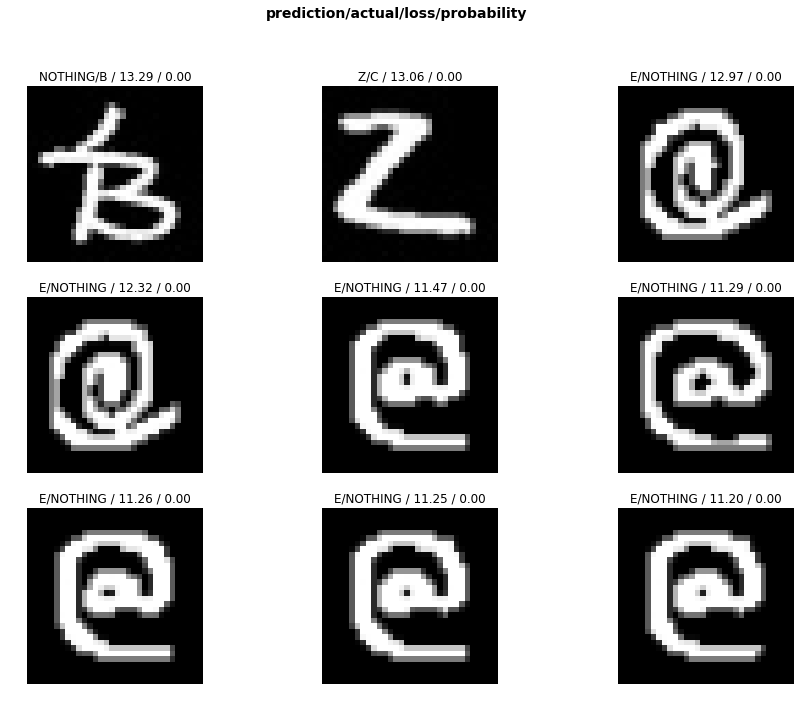

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
doc(interp.plot_top_losses)

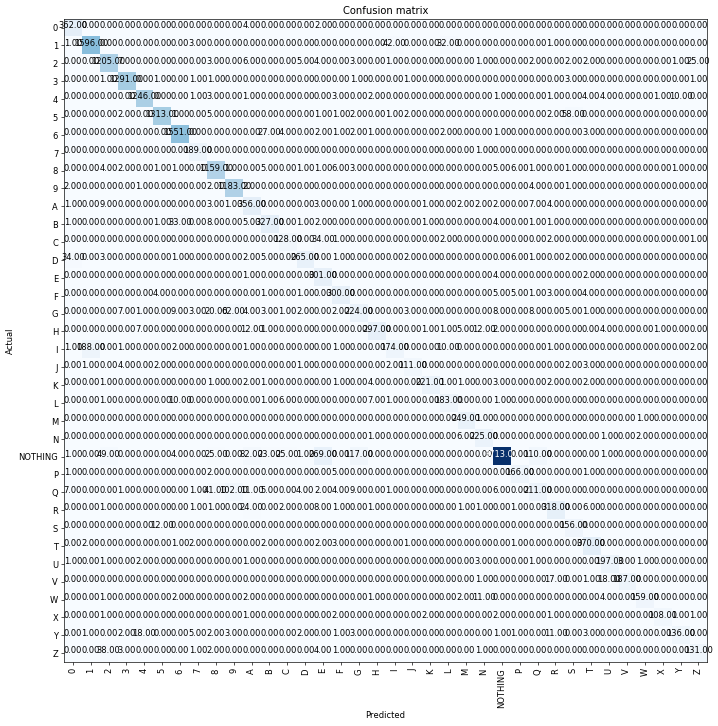

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('NOTHING', 'E', 269),
 ('I', '1', 188),
 ('NOTHING', 'G', 117),
 ('NOTHING', 'Q', 110),
 ('Q', '9', 102),
 ('NOTHING', 'A', 82),
 ('G', '9', 62),
 ('5', 'S', 58),
 ('NOTHING', '2', 49),
 ('1', 'I', 42),
 ('Q', '8', 41),
 ('Z', '2', 38),
 ('C', 'E', 34),
 ('D', '0', 34),
 ('B', '6', 33),
 ('1', 'L', 32),
 ('6', 'B', 27),
 ('2', 'Z', 25),
 ('NOTHING', '8', 25),
 ('NOTHING', 'C', 25),
 ('R', 'A', 24),
 ('NOTHING', 'B', 23),
 ('G', '8', 20),
 ('V', 'U', 18),
 ('Y', '4', 18),
 ('V', 'R', 17),
 ('H', 'A', 12),
 ('H', 'N', 12),
 ('S', '5', 12),
 ('Q', 'A', 11),
 ('W', 'N', 11),
 ('Y', 'R', 11),
 ('4', 'Y', 10),
 ('I', 'L', 10),
 ('L', '6', 10),
 ('A', '2', 9),
 ('G', '6', 9),
 ('Q', 'G', 9),
 ('B', '8', 8),
 ('G', 'NOTHING', 8),
 ('G', 'Q', 8),
 ('R', 'E', 8),
 ('2', '3', 7),
 ('A', 'Q', 7),
 ('G', '3', 7),
 ('H', '4', 7),
 ('L', 'H', 7),
 ('Q', '0', 7),
 ('2', 'A', 6),
 ('8', 'F', 6),
 ('8', 'P', 6),
 ('D', 'P', 6),
 ('L', 'C', 6),
 ('N', 'M', 6),
 ('Q', 'NOTHING', 6),
 ('R', 'T', 6),
 ('2

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

Total time: 06:44
epoch  train_loss  valid_loss  error_rate
1      0.174515    0.336017    0.084843    (06:44)



In [24]:
learn.load('stage-1-resnet34-32px')

In [25]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


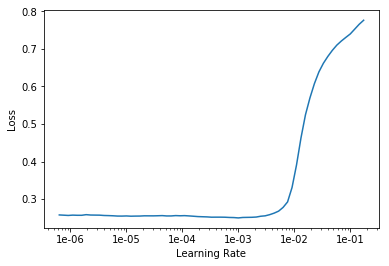

In [26]:
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

Total time: 12:57
epoch  train_loss  valid_loss  error_rate
1      0.242151    0.336390    0.092435    (06:28)
2      0.230165    0.334013    0.090748    (06:28)



That's a pretty accurate model!

In [28]:
learn.save('stage-2-resnet34-32px')
! cp -R {path/'models'} {permanent_path}

In [31]:
! cp -R {path/'models/stage-2-resnet34-32px.pth'} ./models